num_train_faces: 83, num_train_nonfaces: 50
num_test_faces: 82, num_test_nonfaces: 50
[epoch 1] accuracy = 0.8646616541353384
[epoch 2] accuracy = 0.8646616541353384
[epoch 3] accuracy = 0.9548872180451128
[epoch 4] accuracy = 0.9548872180451128
[epoch 5] accuracy = 1.0
[epoch 6] accuracy = 0.9924812030075187
[epoch 7] accuracy = 1.0
[epoch 8] accuracy = 1.0
[epoch 9] accuracy = 1.0
[epoch 10] accuracy = 1.0
[epoch 11] accuracy = 1.0
[epoch 12] accuracy = 1.0
[epoch 13] accuracy = 1.0
[epoch 14] accuracy = 1.0
[epoch 15] accuracy = 1.0
[epoch 16] accuracy = 1.0
[epoch 17] accuracy = 1.0
[epoch 18] accuracy = 1.0
[epoch 19] accuracy = 1.0
[epoch 20] accuracy = 1.0
测试集上的准确率为：0.946969696969697
测试集上的召回率为：0.9878048780487805


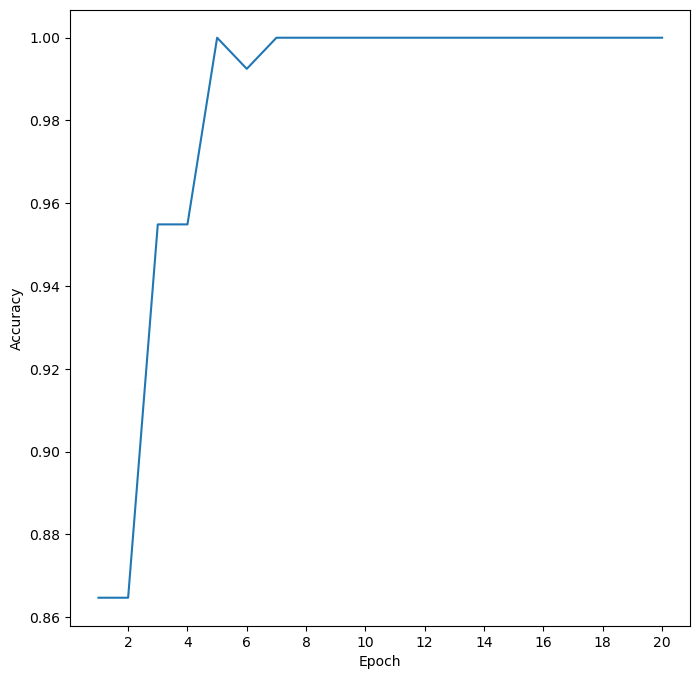

In [3]:
import math
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

def load_and_preprocess_data(folder_faces: str, folder_nonfaces: str,
                             size: tuple[int, int] = (24, 24), train_size: float = 0.5, seed: int = 42):
    # 加载图像，并将图像转化为灰度图，然后重置大小为(24, 24)，最后划分训练集和测试集
    path_faces = glob.glob(os.path.join(folder_faces, '*.pgm'))
    path_nonfaces = glob.glob(os.path.join(folder_nonfaces, '*.jpg'))
    x_faces = []
    y_faces = []
    x_nonfaces = []
    y_nonfaces = []
    for path in path_faces:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # 加载图像并转化为灰度图: [3, H, W] -> [H, W]
        # if img.ndim == 3:
        #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, size) # 将图像重置尺寸为(24, 24): [H, W] -> [24, 24]
        x_faces.append(img)
        y_faces.append(1)
    for path in path_nonfaces:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        x_nonfaces.append(img)
        y_nonfaces.append(-1)
    rand = np.random.RandomState(seed)
    rand.shuffle(x_faces)
    rand.shuffle(x_nonfaces)
    x_faces = np.stack(x_faces) # [n_pos, 24, 24]
    y_faces = np.array(y_faces) # [n_pos]
    x_nonfaces = np.stack(x_nonfaces) # [n_neg, 24, 24]
    y_nonfaces = np.array(y_nonfaces) # [n_neg]
    # 划分训练集和测试集
    n_train_pos = int(np.ceil(x_faces.shape[0] * train_size))
    n_train_neg = int(np.ceil(x_nonfaces.shape[0] * train_size))
    x_train = np.concatenate([x_faces[: n_train_pos], x_nonfaces[: n_train_neg]], axis=0) # [n_train, 24, 24]
    y_train = np.concatenate([y_faces[: n_train_pos], y_nonfaces[: n_train_neg]]) # [n_train]
    x_test = np.concatenate([x_faces[n_train_pos:], x_nonfaces[n_train_neg:]], axis=0) # [n_test, 24, 24]
    y_test = np.concatenate([y_faces[n_train_pos:], y_nonfaces[n_train_neg:]], axis=0) # [n_test]
    print(f'num_train_faces: {np.sum(y_train == 1)}, num_train_nonfaces: {np.sum(y_train == -1)}\n'
          f'num_test_faces: {np.sum(y_test == 1)}, num_test_nonfaces: {np.sum(y_test == -1)}')
    return x_train, y_train, x_test, y_test

def feature_extraction(x_train_img: np.ndarray, x_test_img: np.ndarray, num_features: int = 2000):
    def define_feature_types():
        # 定义从图像中提取哪些特征

        feature_types: list[tuple[str, int, int, int, int]] = []
        
        H = x_train_img.shape[1]
        W = x_train_img.shape[2]
        
        # 水平双矩形特征：提取左右明暗对比信息
        # 美剧水平双矩形的尺寸
        for h in range(1, H + 1):
            for w in range(2, W + 1, 2):
                # 枚举水平双矩形左上角的像素的位置
                for x in range(0, H - h + 1):
                    for y in range(0, W - w + 1):
                        feature_types.append(('double_horizontal', h, w, x, y))
                        if len(feature_types) == num_features:
                            return feature_types
        
        # 垂直双矩形特征：提取上下明暗对比信息
        # 枚举垂直双矩形的尺寸
        for h in range(2, H + 1, 2):
            for w in range(1, W + 1):
                # 枚举垂直双矩形左上角的像素的位置
                for x in range(0, H - h + 1):
                    for y in range(0, W - w + 1):
                        feature_types.append(('double_vertical', h, w, x, y))
                        if len(feature_types) == num_features:
                            return feature_types
        
        # 水平三矩形特征：提取水平两侧与中间的明暗对比信息（如亮暗亮、暗亮暗）
        # 枚举水平三矩形的尺寸
        for h in range(1, H + 1):
            for w in range(3, W + 1, 3):
                # 枚举水平三矩形左上角的像素的位置
                for x in range(0, H - h + 1):
                    for y in range(0, W - w + 1):
                        feature_types.append(('triple_horizontal', h, w, x, y))
                        if len(feature_types) == num_features:
                            return feature_types

        # 垂直三矩形特征：提取上下两侧与中间的明暗对比信息（如亮暗亮、暗亮暗）
        # 枚举垂直三矩形的尺寸
        for h in range(3, H + 1, 3):
            for w in range(1, W + 1):
                # 枚举垂直三矩形的位置
                for x in range(0, H - h + 1):
                    for y in range(0, W - w + 1):
                        feature_types.append(('triple_vertical', h, w, x, y))
                        if len(feature_types) == num_features:
                            return feature_types

        # 四矩形特征：提取左上、右下与左下、右上的明暗对比信息（如：左上与右下亮、左下与右上暗）
        # 枚举四矩形的尺寸
        for h in range(2, H + 1, 2):
            for w in range(2, W + 1, 2):
                # 枚举四矩形的位置
                for x in range(0, H - h + 1):
                    for y in range(0, W - w + 1):
                        feature_types.append(('quadruple', h, w, x, y))
                        if len(feature_types) == num_features:
                            return feature_types

        return feature_types

    def compute_sum(img_pre_sum: np.ndarray, h, w, x, y):
        # 利用积分图在常数时间内求图像中某个矩形包含的像素值的和
        # 注意x, y是在原图中矩形左上角像素的坐标，不是在积分图中的坐标
        return img_pre_sum[x + h, y + w] - img_pre_sum[x + h, y] - img_pre_sum[x, y + w] + img_pre_sum[x, y]

    def compute_feature(img_pre_sum: np.ndarray, feature_type: tuple[str, int, int, int, int]):
        # 计算图像的某个特征feature_type
        attr, h, w, x, y = feature_type
        if attr == 'double_horizontal':
            w2 = w // 2
            return compute_sum(img_pre_sum, h, w2, x, y) - compute_sum(img_pre_sum, h, w2, x, y + w2)
        elif attr == 'double_vertical':
            h2 = h // 2
            return compute_sum(img_pre_sum, h2, w, x, y) - compute_sum(img_pre_sum, h2, w, x + h2, y)
        elif attr == 'triple_horizontal':
            w3 = w // 3
            return (compute_sum(img_pre_sum, h, w3, x, y) + compute_sum(img_pre_sum, h, w3, x, y + w3 + w3)
                    - compute_sum(img_pre_sum, h, w3, x, y + w3))
        elif attr == 'triple_vertical':
            h3 = h // 3
            return (compute_sum(img_pre_sum, h3, w, x, y) + compute_sum(img_pre_sum, h3, w, x + h3 + h3, y)
                    - compute_sum(img_pre_sum, h3, w, x + h3, y))
        elif attr == 'quadruple':
            h2 = h // 2
            w2 = w // 2
            return (compute_sum(img_pre_sum, h2, w2, x, y) + compute_sum(img_pre_sum, h2, w2, x + h2, y + w2)
                    - compute_sum(img_pre_sum, h2, w2, x, y + w2) - compute_sum(img_pre_sum, h2, w2, x + h2, y))
        else:
            return None

    def img_feature_extraction(img: np.ndarray, feature_types: list[tuple[str, int, int, int, int]]):
        # 将图像转化为积分图
        img_pre_sum = cv2.integral(img)
        # 提取图像的Haar特征
        img_feature = []
        for feature_type in feature_types:
            img_feature.append(compute_feature(img_pre_sum, feature_type))
        img_feature = np.array(img_feature)
        return img_feature

    feature_types = define_feature_types()
    x_train_feature = []
    for i in range(x_train_img.shape[0]):
        feature = img_feature_extraction(x_train_img[i], feature_types)
        # 特征归一化
        avg = np.average(feature, axis=0, keepdims=True)
        std = np.std(feature, axis=0, keepdims=True) + 1e-8 # 防止除0异常
        feature = (feature - avg) / std
        x_train_feature.append(feature)
    x_train_feature = np.stack(x_train_feature) # [n_train, feature_dim]
    x_test_feature = []
    for i in range(x_test_img.shape[0]):
        feature = img_feature_extraction(x_test_img[i], feature_types)
        # 特征归一化
        avg = np.average(feature, axis=0, keepdims=True)
        std = np.std(feature, axis=0, keepdims=True) + 1e-8  # 防止除0异常
        feature = (feature - avg) / std
        x_test_feature.append(feature)
    x_test_feature = np.stack(x_test_feature)

    return x_train_feature, x_test_feature

class AdaBoost:
    def __init__(self, T: int):
        self.T = T # 基础分类器的个数
        self.classifiers = [DecisionTreeClassifier(max_depth=1) for _ in range(T)] # 采用决策树作为基础分类器
        self.alpha = [0.0 for _ in range(T)] # 每个分类器对应一个权重alpha_t

    def train(self, x: np.ndarray, y: np.ndarray):
        n = x.shape[0] # 样本数量
        omega = [1 / n for _ in range(n)] # 每个样本对应一个权重，一开始全部初始化为1/n
        y_preds = []
        history = {'accuracy': []}
        for t in range(self.T):
            # 训练基础分类器DecisionTree
            self.classifiers[t].fit(x, y, sample_weight=omega)
            y_pred = self.classifiers[t].predict(x)
            y_preds.append(y_pred)
            judge = y_pred == y
            # 计算错误率
            error_rate = 0.0
            for i in range(n):
                if judge[i] == False:
                    error_rate += omega[i]
            # 计算alpha_t
            self.alpha[t] = 0.5 * math.log((1.0 - error_rate) / (error_rate + 1e-8))
            # 更新权重，为防止数值溢出进行优化
            if self.alpha[t] >= 0.0:
                for i in range(n):
                    omega[i] *= math.exp(-self.alpha[t] - self.alpha[t]) if judge[i] == True else 1
            else:
                for i in range(n):
                    omega[i] *= 1 if judge[i] == True else math.exp(self.alpha[t] + self.alpha[t])
            sum_omega = np.sum(np.array(omega))
            omega = [i / sum_omega for i in omega]
            # 在训练集上评估
            current_y_pred = np.zeros(n)
            for i in range(t + 1):
                current_y_pred = current_y_pred + y_preds[i] * self.alpha[i]
            for i in range(n):
                current_y_pred[i] = 1 if current_y_pred[i] > 0 else -1
            accuracy = np.sum(current_y_pred == y) / n
            print(f'[epoch {t + 1}] accuracy = {accuracy}')
            history['accuracy'].append(accuracy)
        return history

    def test(self, x: np.ndarray, y: np.ndarray):
        n = x.shape[0]
        y_pred = np.zeros(n)
        for t in range(self.T):
            base_y_pred = self.classifiers[t].predict(x)
            y_pred = y_pred + base_y_pred * self.alpha[t]
        for i in range(n):
            y_pred[i] = 1 if y_pred[i] > 0 else -1
        accuracy = np.sum(y_pred == y) / n # 准确率
        count_pos_pos = 0 # 实际为正样本、且被模型预测为正样本（预测对的正样本）的个数
        count_pos = 0 # 正样本的个数
        for i in range(n):
            if y[i] == 1:
                count_pos += 1
                if y_pred[i] == 1:
                    count_pos_pos += 1
        recall = count_pos_pos / count_pos
        print(f'测试集上的准确率为：{accuracy}')
        print(f'测试集上的召回率为：{recall}')

def main(T: int):
    x_train, y_train, x_test, y_test = load_and_preprocess_data('faces', 'nonfaces')
    x_train_feature, x_test_feature = feature_extraction(x_train, x_test)
    model = AdaBoost(T)
    history = model.train(x_train_feature, y_train)
    model.test(x_test_feature, y_test)
    
    plt.figure(figsize=(8, 8))
    plt.xlabel('Epoch')
    plt.xticks([t for t in range(2, T + 1, 2)])
    plt.ylabel('Accuracy')
    plt.plot([t for t in range(1, T + 1)], history['accuracy'])
    plt.show()

if __name__ == '__main__':
    main(20)